# Exercise 3: Visualization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Importing MNIST dataset

In [2]:
# Load mnist from keras dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalizing pixel values
train_images, test_images = train_images.astype('float32')/255, test_images.astype('float32')/255

# reshape images
train_images, test_images = np.expand_dims(train_images, -1), np.expand_dims(test_images, -1)

print('train_images shape: {}'.format(train_images.shape))
print('{} train samples'.format(train_images.shape[0]))
print('{} test samples'.format(test_images.shape[0]))

train_images shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


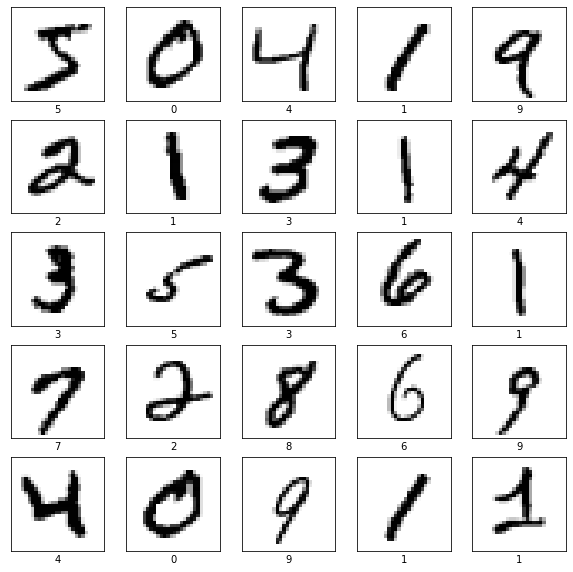

In [3]:
# print random images from dataset
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    
    plt.xlabel(train_labels[i])
plt.show()

## Create CNN model

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def Convolution(input_tensor, filters):
    x = layers.Conv2D(filters=filters,
                      kernel_size=(3,3),
                      padding='same',
                      strides=(1,1),
                      activation='relu'
                     ) (input_tensor)
    
    return x

def simpleCNN(input_shape, name):
    inputs = layers.Input((input_shape))
    
    conv1 = Convolution(inputs, 32)
    maxp1 = layers.MaxPooling2D(pool_size=(3,3)) (conv1)
    conv2 = Convolution(maxp1, 64)
    maxp2 = layers.MaxPooling2D(pool_size=(3,3)) (conv2)
    conv3 = Convolution(maxp2, 64)
    maxp3 = layers.MaxPooling2D(pool_size=(3,3)) (conv3)
    
    flatten = layers.Flatten() (maxp3)
    
    dense = layers.Dense(64, activation='relu') (flatten)
    
    output = layers.Dense(10, activation=None) (dense)
    
    model = Model(
    inputs = [inputs],
    outputs = [output],
    name = name
    )
    
    return model

### Train the model

In [5]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy as BinaryCross

# initiate and configure the model
input_shape = train_images[0].shape
cnn = simpleCNN(input_shape, "Simple_CNN")


# compile and train the model for one epoch
cnn.compile(
    optimizer=SGD(learning_rate=1e-6),
    loss=BinaryCross(),
    metrics=['accuracy']
)

history = cnn.fit(x=train_images, y=train_labels, epochs=1, shuffle=True, validation_split=0.2, verbose=1)
cnn.save_weights('./cnn_weights', overwrite=True, save_format='tf')

1500/1500 [==============================] - 32s 21ms/step - loss: 33.6593 - accuracy: 0.0957 - val_loss: 26.2569 - val_accuracy: 0.0965


### Extract features from flatten layer

In [6]:
# cut off the fully-connected layer and set trainable to false
featExtr = Model(inputs=cnn.input, outputs=cnn.get_layer(index=7).output)
featExtr.trainable = False
featExtr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0     

In [7]:
# Extracting features
flatten_out = featExtr.predict(x=train_images, verbose=1)

1875/1875 [==============================] - 15s 8ms/step


#### Visualizing features with PCA and t-SNE
Features of trained CNN for 1 epoc with learning_rate 1e-6.

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(flatten_out).transform(flatten_out)

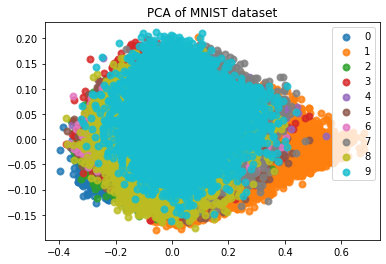

In [9]:
targets = np.unique(train_labels)

plt.figure()
lw = 2

for i in targets:
    plt.scatter(pca[train_labels == i, 0], pca[train_labels == i, 1], alpha=.8, lw=lw,
                label=targets[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MNIST dataset')
plt.show()

In [ ]:
from time import time
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

y = train_labels

# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9},
                 label=y[i])

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
#            shown_images = np.r_[shown_images, [X[i]]]
#            imagebox = offsetbox.AnnotationBbox(
#                offsetbox.OffsetImage(train_images[i], cmap=plt.cm.gray_r),
#                X[i])
#            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.legend(loc='best', shadow=False)
    if title is not None:
        plt.title(title)


In [11]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(flatten_out)

In [ ]:
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

No handles with labels found to put in legend.


(60000, 2)